In [93]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image
import sklearn
import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats
from scipy.stats import mannwhitneyu

In [2]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [48]:
def loadMcResult(sampleShape, mean, path="dataFastPerm/uniform/data"):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv(path + "_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv(path + "_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv(path + "_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv(path + "_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [4]:
def run_test(X,Y,bins, parallel=True, midP=False):

    
    
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = SGM.p_values[0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])

    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [5]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
    
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pe_list, TIME
    

In [6]:
def ttest(X_list, y_list):
    pt_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_t = list()
    
        for x, y in zip(Xp, yp):
            
            t, p = ttest_ind(y, x)
            p = p/2
            if t<0:
                p = 1-p
       
            p_t.append(p)
            
        pt_list.append(p_t)

    
    return pt_list
    

In [7]:
def mannWhitney(X_list, y_list, alternative="less"):
    assert alternative in ["less","greater","two-tail"]
    pmw_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_mw = list()
    
        for x, y in zip(Xp, yp):
            

            p = mannwhitneyu(x, y, alternative=alternative)[1]
            
            
            p_mw.append(p)
            
        pmw_list.append(p_mw)

    
    return pmw_list

### Compare parallelized and MC version

### Calibration-plot

In [103]:
from scipy import stats
def r2(x, y):
    #return stats.pearsonr(x, y)[0] ** 2
    return mean_squared_error(x,y)

def my_scatter_plot(df,save_name):
    sns.set(style="white")
    sns.set_context("talk")
    low = min(df["Theoretical p-value"])
    hi = max(df["Theoretical p-value"])
    f, ax = plt.subplots(figsize=(7, 7))
    ax.set(xscale="log", yscale="log")
    
    err2 = r2(df["Observed p-value"], pDf["Theoretical p-value"])
    
    g=sns.regplot(x='Theoretical p-value', y ='Observed p-value', data=df,  ax=ax, fit_reg=False, 
                  scatter_kws={"s": 5})
    g.plot([low,hi], [low,hi], 'k-', linewidth=.5)
    
    sns.despine()
    plt.title("MSE : {}".format(np.around(err2,6)))
    f.tight_layout()
    f.savefig(save_name)

In [9]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '/' + prefix

In [10]:
path = "figures/paralellVsFastApprox"

## Sample sizes of X and Y

In [170]:
sampleShape = [10,50,100,150,200,250,300]

# Calibration: with $X \sim N(5.0,1)$ and $Y\sim N(5.0,1)$

## Load data

In [171]:
mean=5


In [172]:
X_list_, y_list_, p_val_list_, time_listMc_ = loadMcResult(sampleShape, mean)

In [174]:
pe_list_, TIME_ = shiftMethod(np.asarray(X_list_), np.asarray(y_list_), 40)


In [175]:
pmw_list5_2 = mannWhitney(np.asarray(X_list_), np.asarray(y_list_))

# $|n|=|m|=10$

## Parallelized exact test

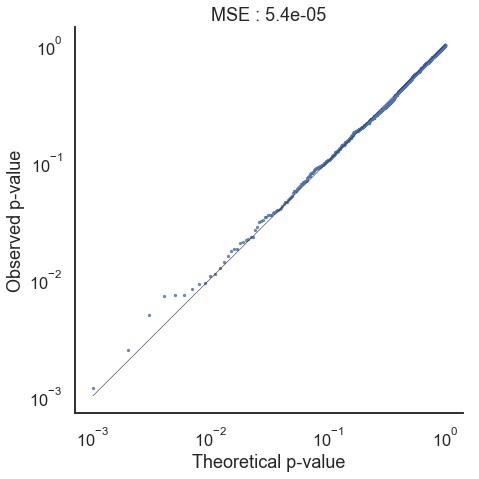

In [176]:
pDf = getdf(pe_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

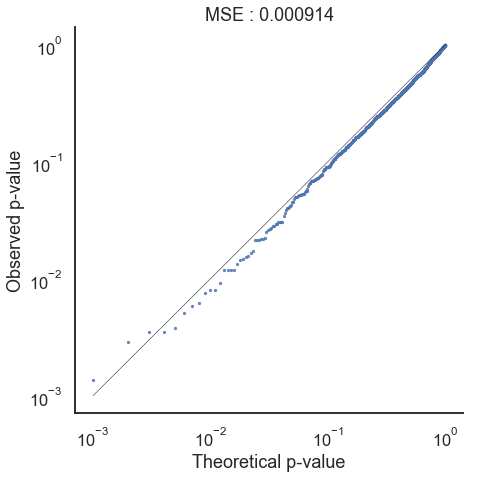

In [177]:
pDf = getdf(p_val_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

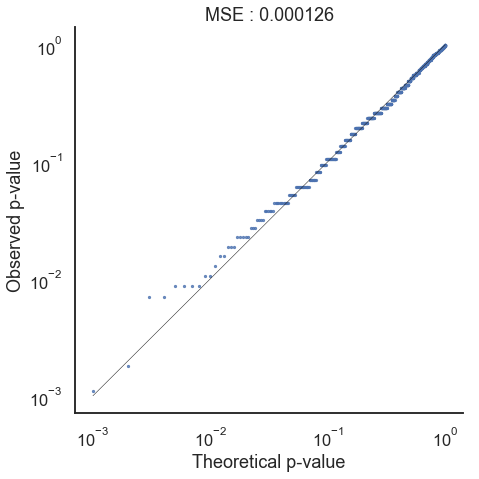

In [178]:
pDf = getdf(pmw_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

In [179]:
pt_list5_2 = ttest(np.asarray(X_list_), np.asarray(y_list_))

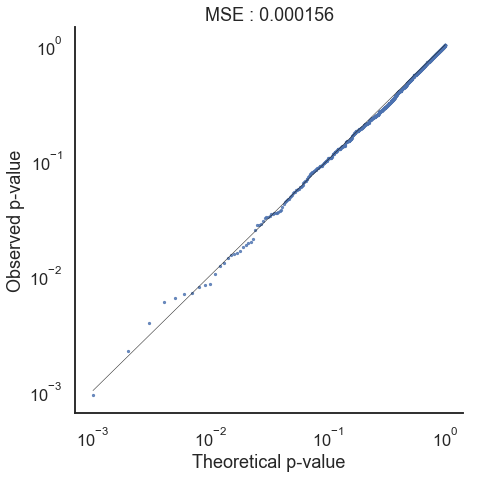

In [180]:
pDf = getdf(pt_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=50$

## Parallelized exact test

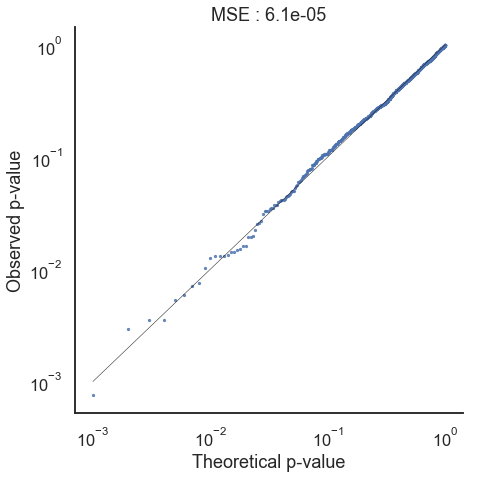

In [181]:
pDf = getdf(pe_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

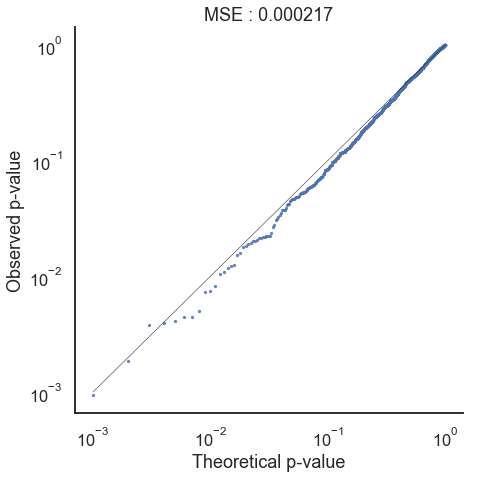

In [182]:
pDf = getdf(p_val_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann whitney

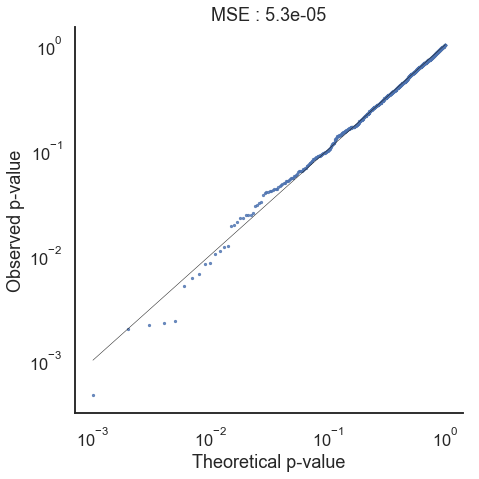

In [183]:
pDf = getdf(pmw_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

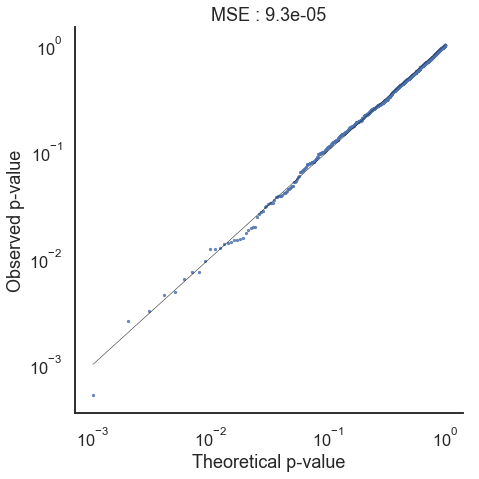

In [184]:
pDf = getdf(pt_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=100$

## Parallelized exact test

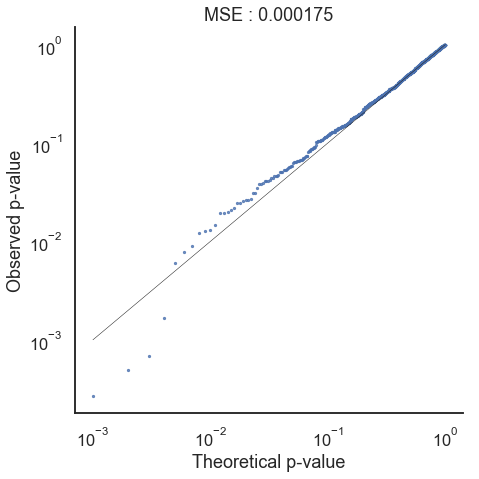

In [185]:
pDf = getdf(pe_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximations

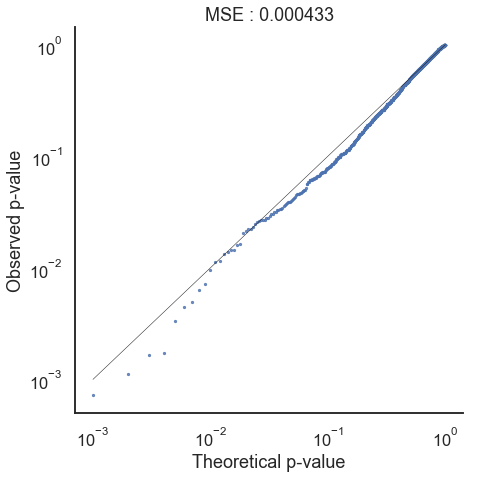

In [186]:
pDf = getdf(p_val_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

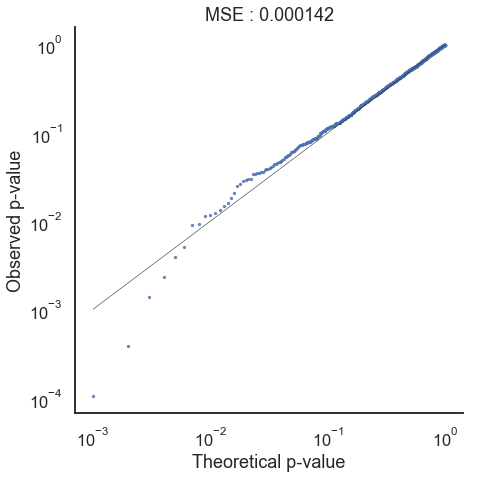

In [187]:
pDf = getdf(pmw_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

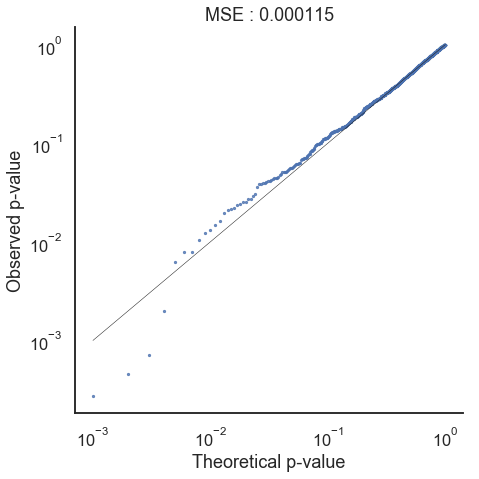

In [188]:
pDf = getdf(pt_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=150$

## Parallelized exact test

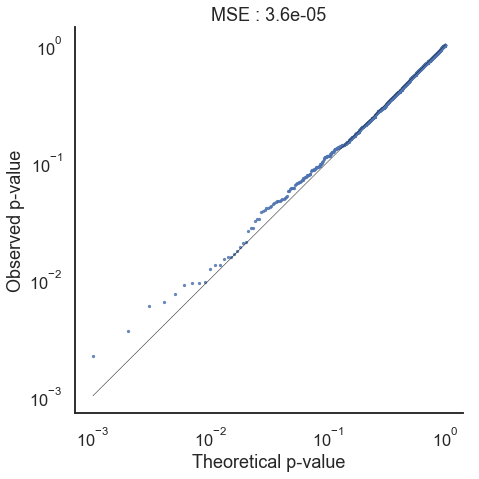

In [189]:
pDf = getdf(pe_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

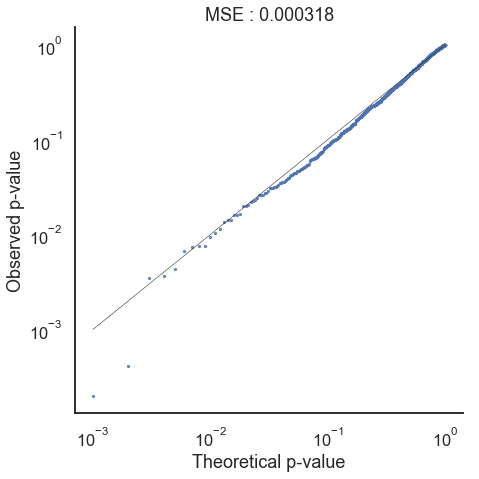

In [190]:
pDf = getdf(p_val_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

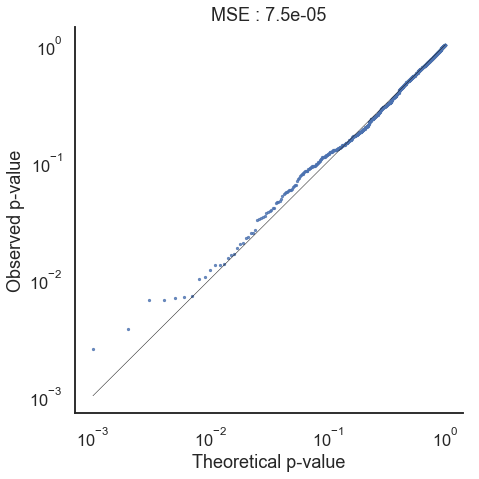

In [191]:
pDf = getdf(pmw_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

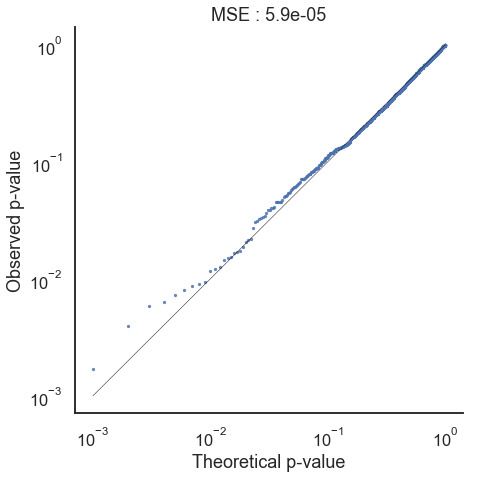

In [192]:
pDf = getdf(pt_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=200$

## Parallelized exact test

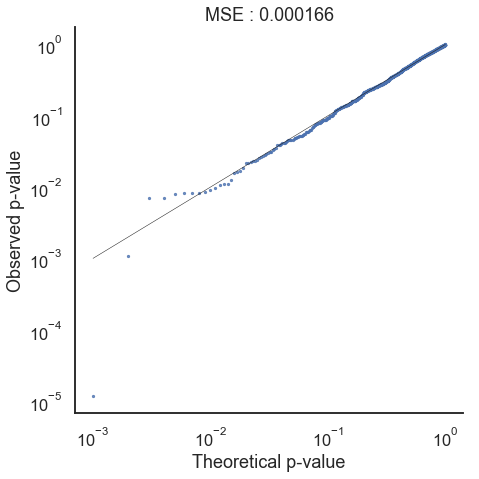

In [193]:
pDf = getdf(pe_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

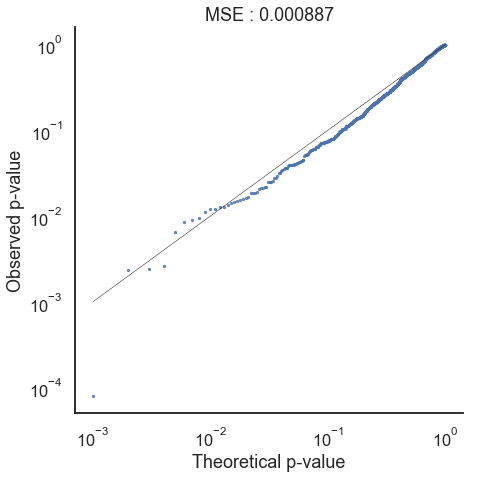

In [194]:
pDf = getdf(p_val_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

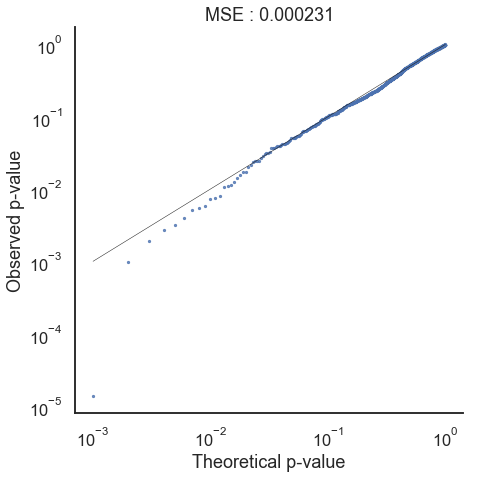

In [195]:
pDf = getdf(pmw_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

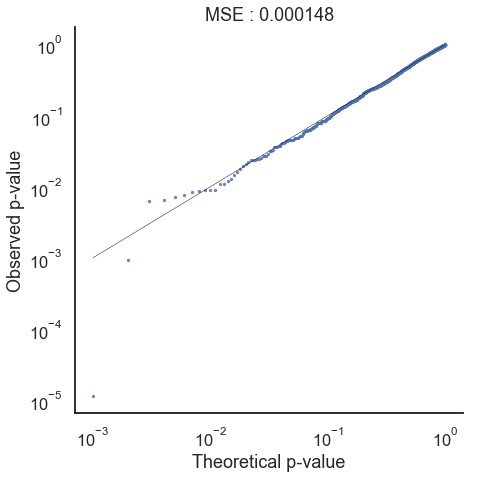

In [196]:
pDf = getdf(pt_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## $|n|=|m|=250$


## Parallelized exact test

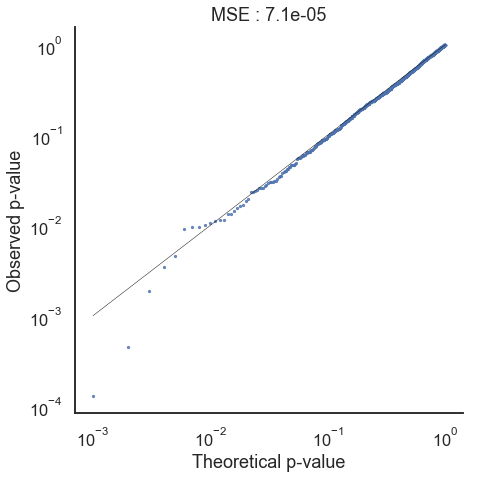

In [197]:
pDf = getdf(pe_list_[5], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

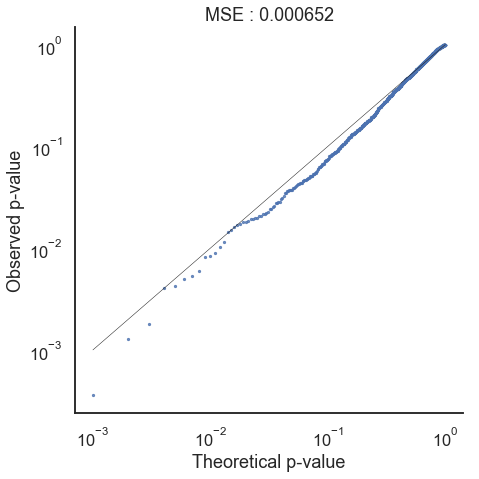

In [198]:
pDf = getdf(p_val_list_[5], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

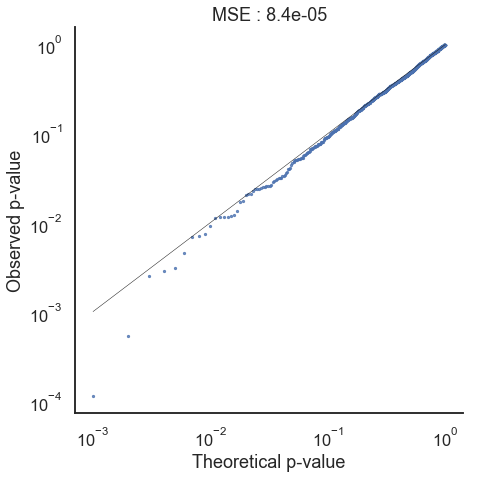

In [199]:
pDf = getdf(pmw_list5_2[5], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

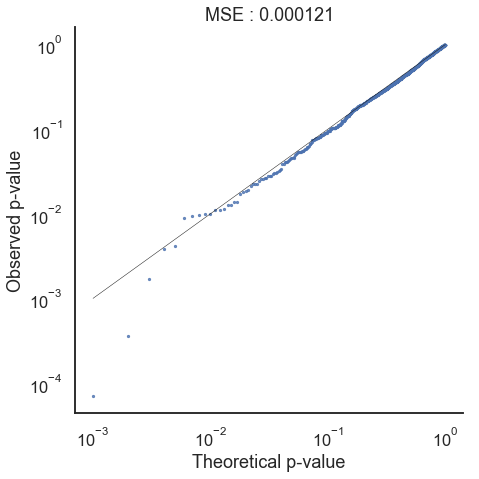

In [200]:
pDf = getdf(pt_list5_2[5], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## $|n|=|m|=300$


## Parallelized exact test

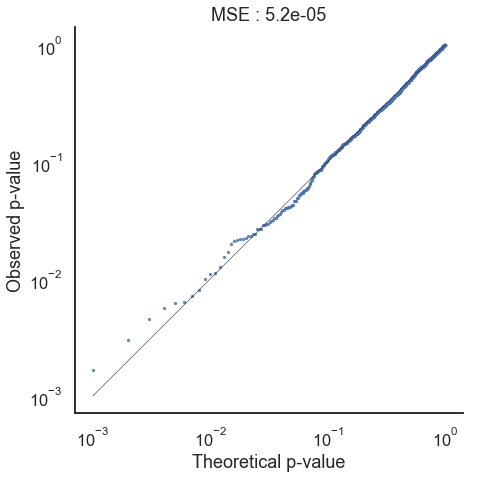

In [201]:
pDf = getdf(pe_list_[6], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Fast approximation

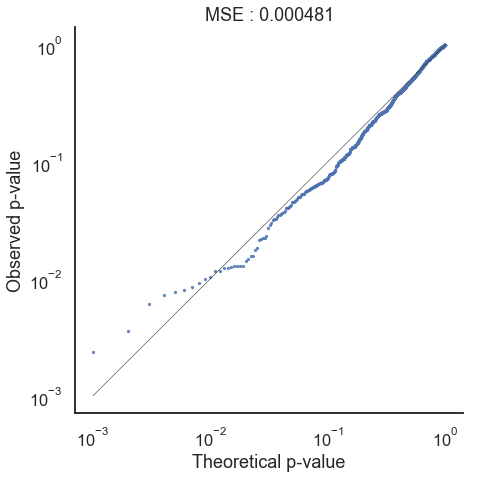

In [202]:
pDf = getdf(p_val_list_[6], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## Mann Whitney

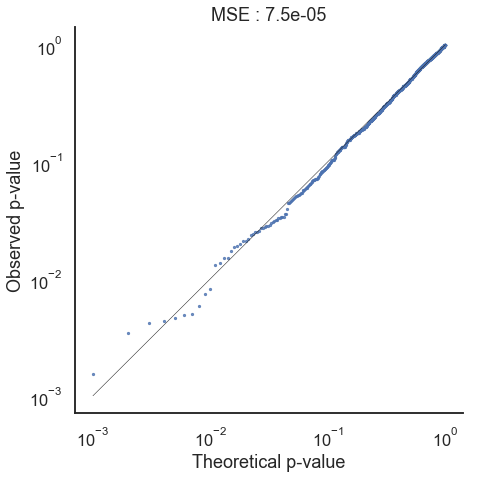

In [203]:
pDf = getdf(pmw_list5_2[6], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

## t-test

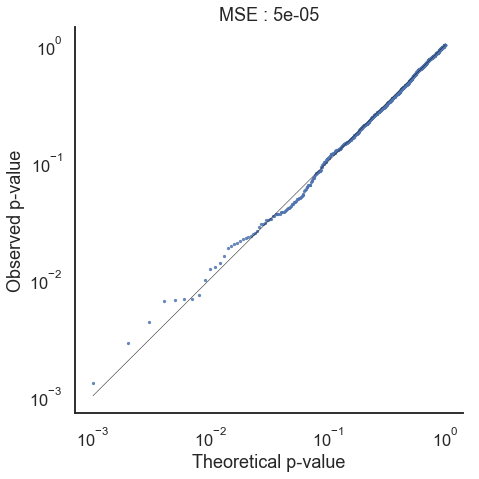

In [204]:
pDf = getdf(pt_list5_2[6], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Calibration: with $X \sim \beta (0.5,0.5)$ and $Y\sim \beta(0.5,0.5)$

In [76]:
mean=0.5
sampleShape = [10,50,100,150,200]

In [77]:
X_list_, y_list_, p_val_list_, time_listMc_ = loadMcResult(sampleShape, mean, path="dataFastPerm/uniform/beta_data")

In [78]:
pe_list_, TIME_ = shiftMethod(np.asarray(X_list_), np.asarray(y_list_), 40)


In [79]:
pmw_list5_2 = mannWhitney(np.asarray(X_list_), np.asarray(y_list_))

# $|n|=|m|=10$

# Parallelized exact

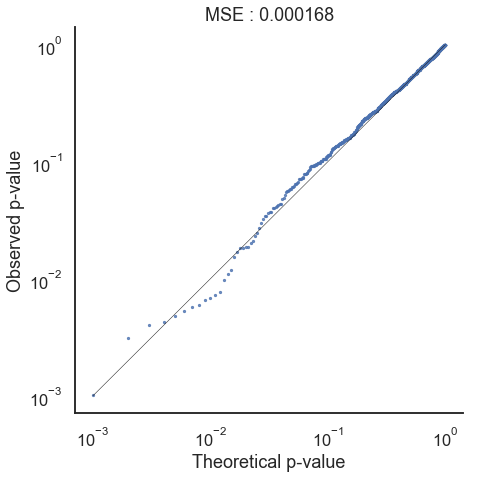

In [104]:
pDf = getdf(pe_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

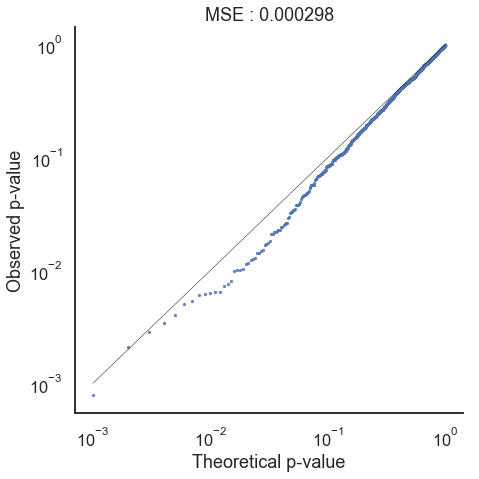

In [105]:
pDf = getdf(p_val_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

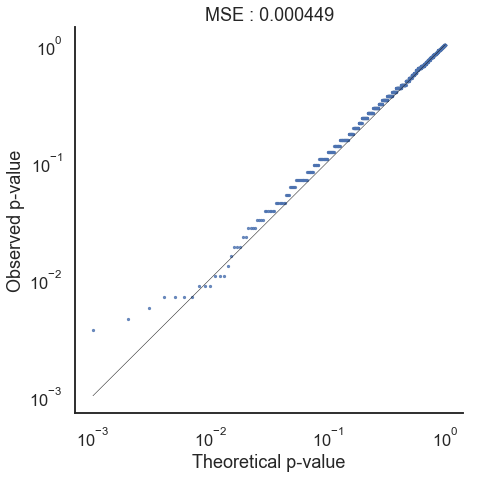

In [106]:
pDf = getdf(pmw_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

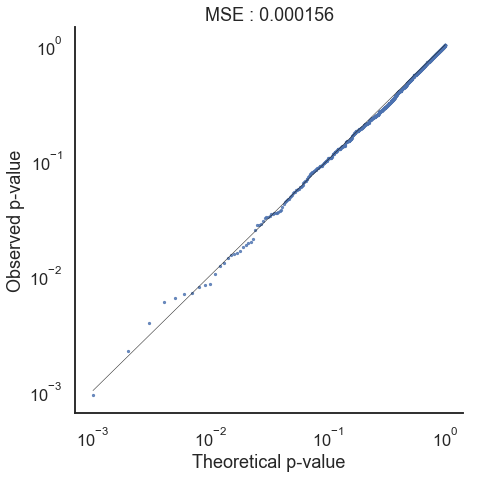

In [107]:
pDf = getdf(pt_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=50$

# Paralellized exact

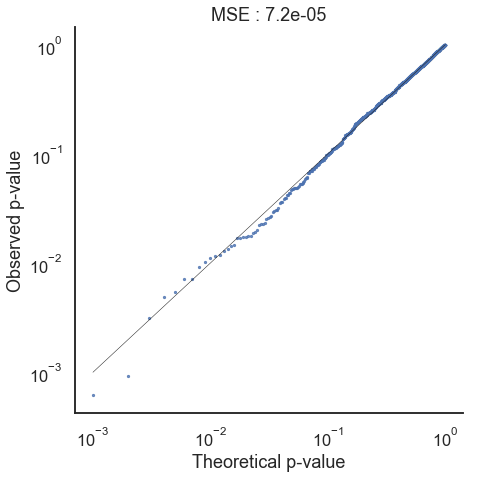

In [108]:
pDf = getdf(pe_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

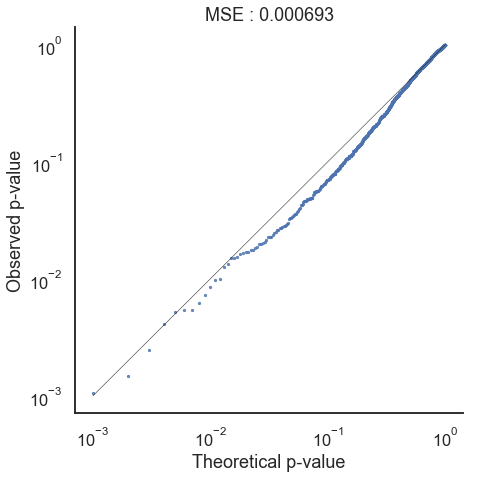

In [109]:
pDf = getdf(p_val_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

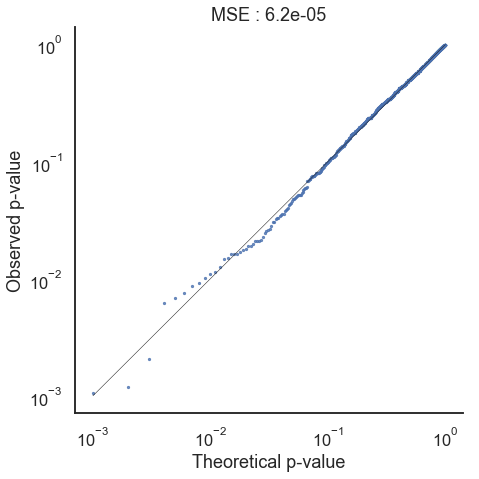

In [110]:
pDf = getdf(pmw_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

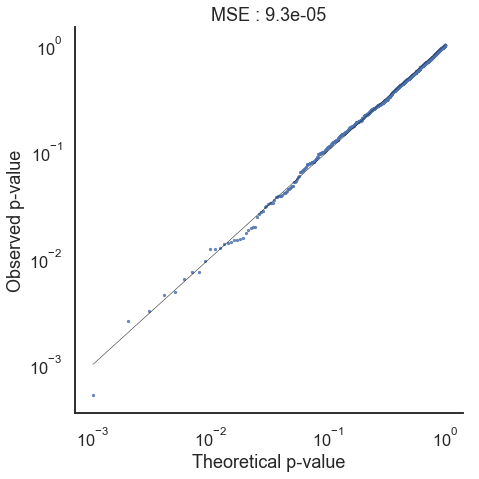

In [111]:
pDf = getdf(pt_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=100$

# Parallelized exact

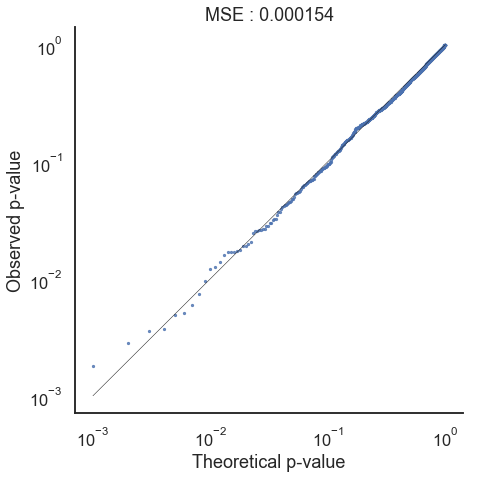

In [112]:
pDf = getdf(pe_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

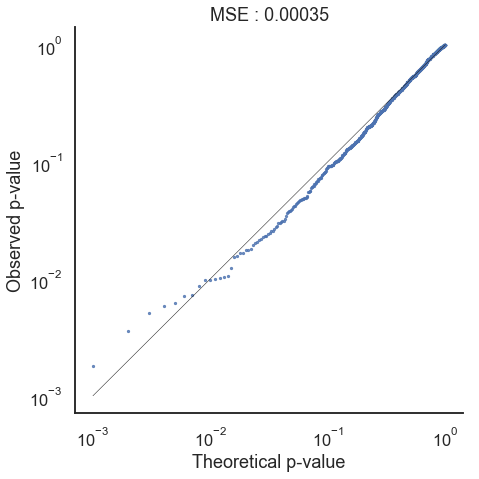

In [113]:
pDf = getdf(p_val_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

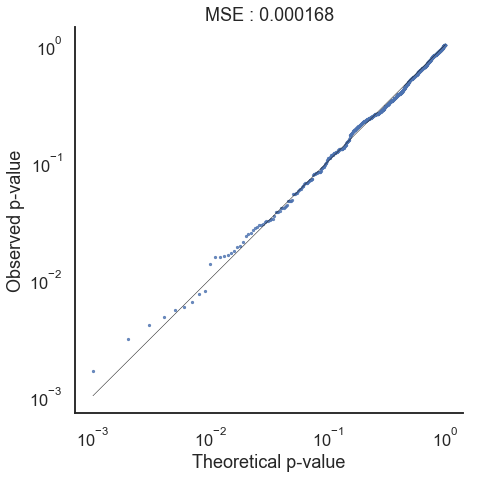

In [114]:
pDf = getdf(pmw_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

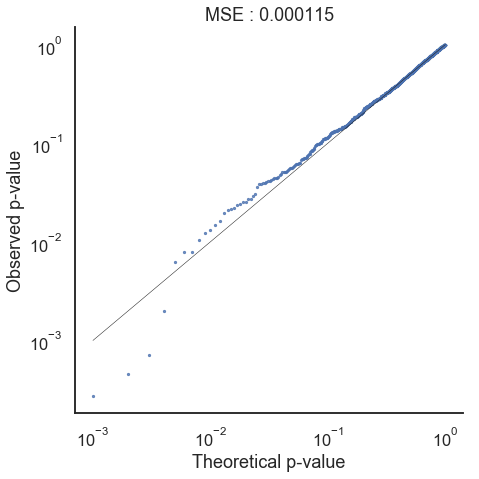

In [115]:
pDf = getdf(pt_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=150$


# Parallelized exact

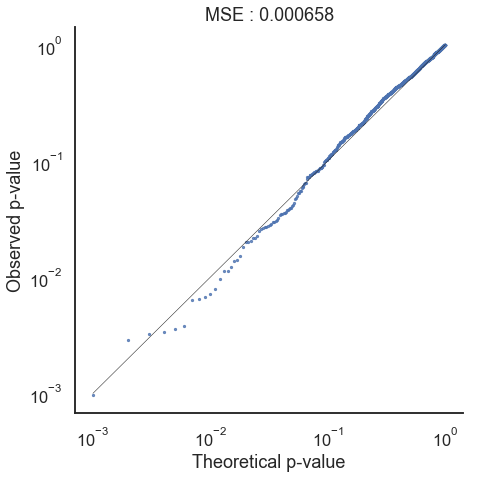

In [118]:
pDf = getdf(pe_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

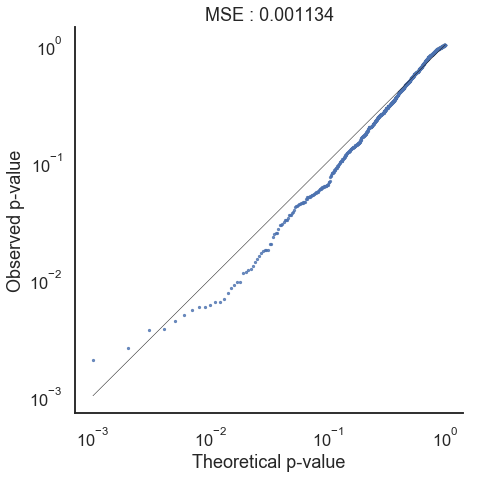

In [119]:
pDf = getdf(p_val_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann whitney

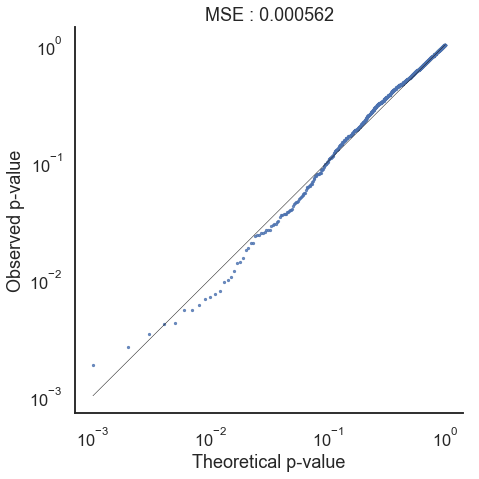

In [120]:
pDf = getdf(pmw_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

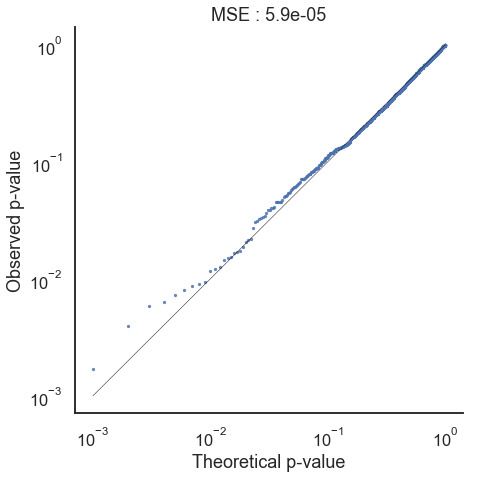

In [121]:
pDf = getdf(pt_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=200$

# Parallelized exact

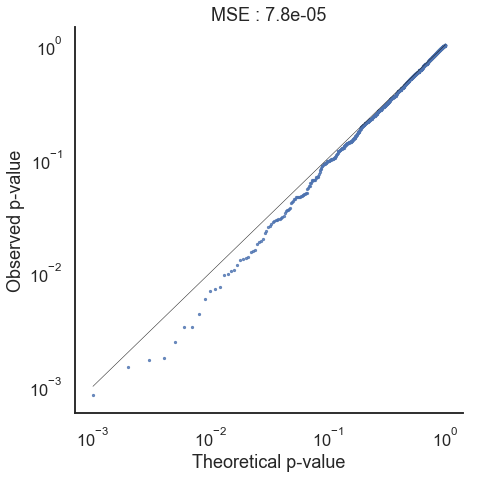

In [122]:
pDf = getdf(pe_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

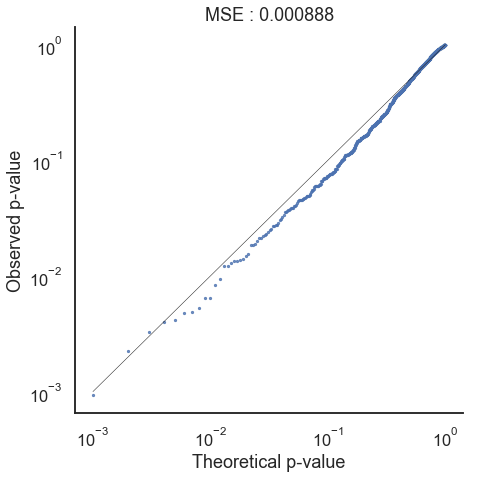

In [124]:
pDf = getdf(p_val_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

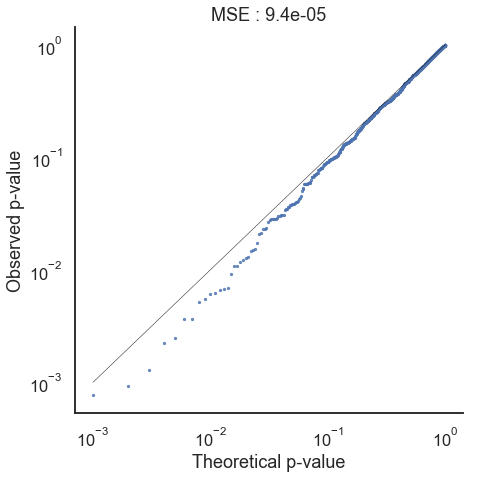

In [125]:
pDf = getdf(pmw_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

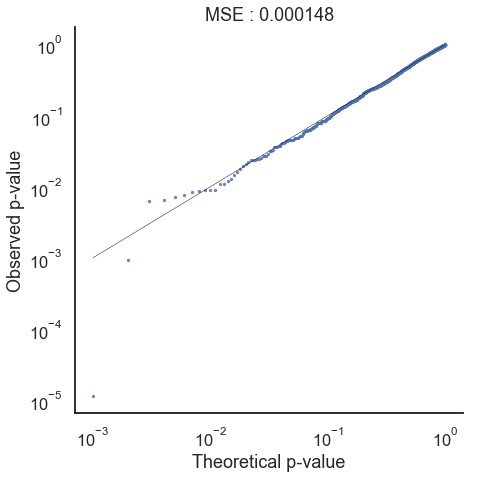

In [126]:
pDf = getdf(pt_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Calibration: with $X \sim \beta (2,5)$ and $Y\sim \beta(2,5)$

In [223]:
mean=2
sampleShape = [10,50, 100, 150, 200]

In [224]:

X_list_, y_list_, p_val_list_, time_listMc_ = loadMcResult(sampleShape, mean, path="dataFastPerm/uniform/beta_data")

In [225]:
pe_list_, TIME_ = shiftMethod(np.asarray(X_list_), np.asarray(y_list_), 40)

In [226]:
pmw_list5_2 = mannWhitney(np.asarray(X_list_), np.asarray(y_list_))

# $|n|=|m|=10$

# Parallelized exact

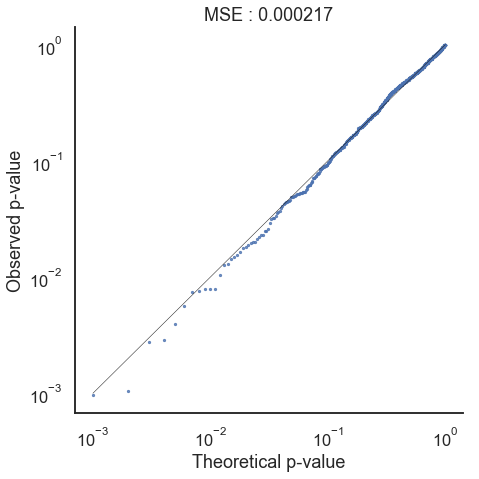

In [209]:
pDf = getdf(pe_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

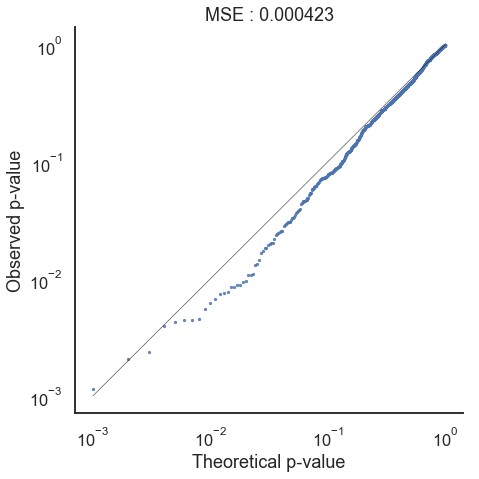

In [210]:
pDf = getdf(p_val_list_[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

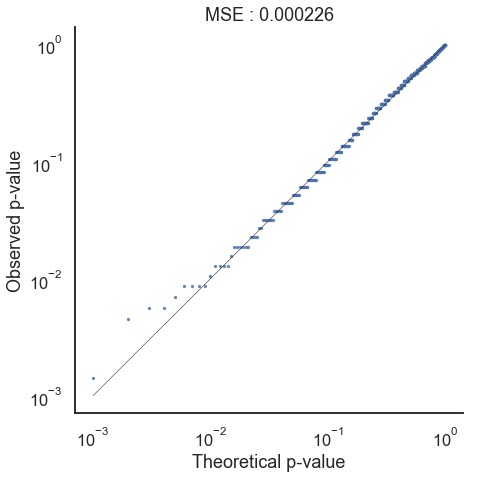

In [211]:
pDf = getdf(pmw_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

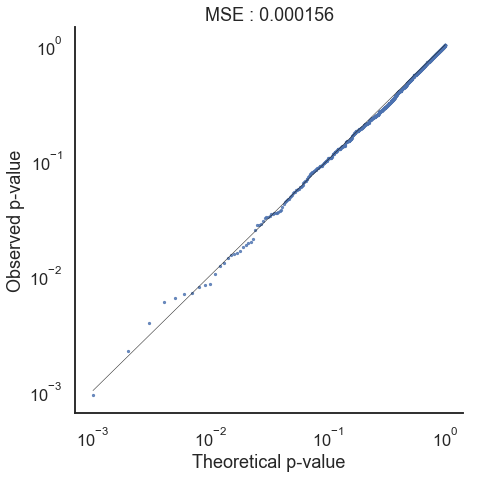

In [212]:
pDf = getdf(pt_list5_2[0], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=50$


# Parallelized exact

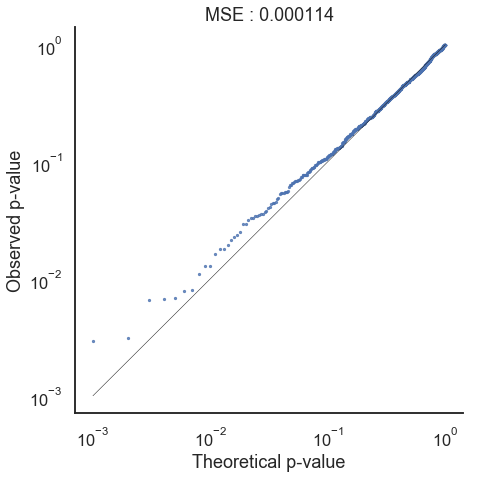

In [213]:
pDf = getdf(pe_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

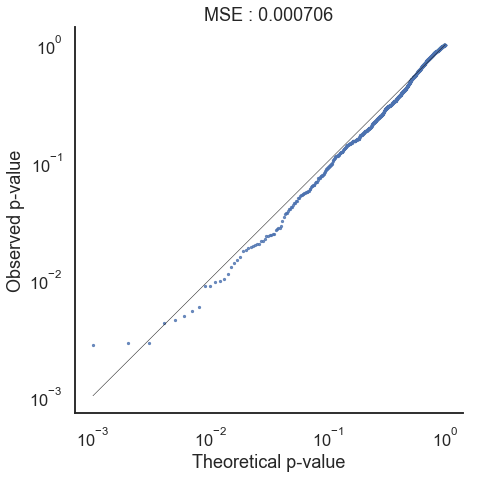

In [214]:
pDf = getdf(p_val_list_[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

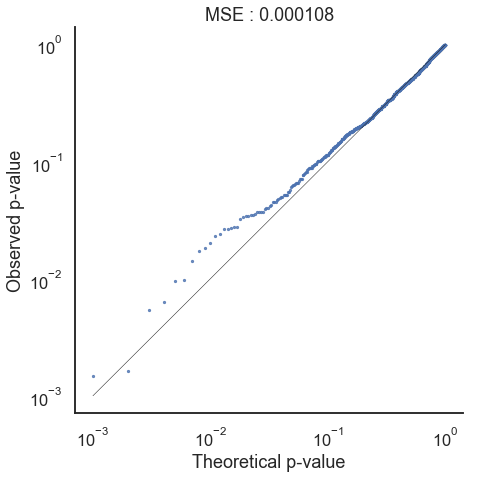

In [215]:
pDf = getdf(pmw_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

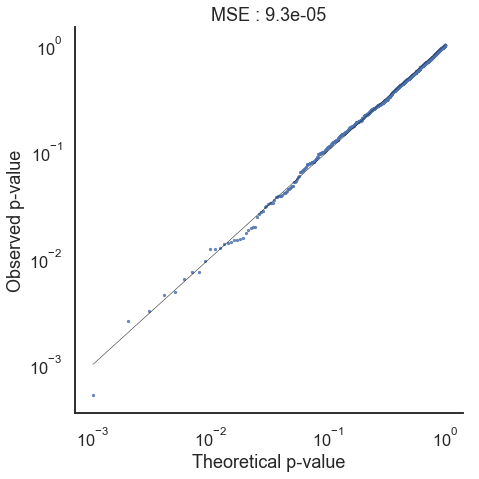

In [216]:
pDf = getdf(pt_list5_2[1], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=100$


# Parallelized exact

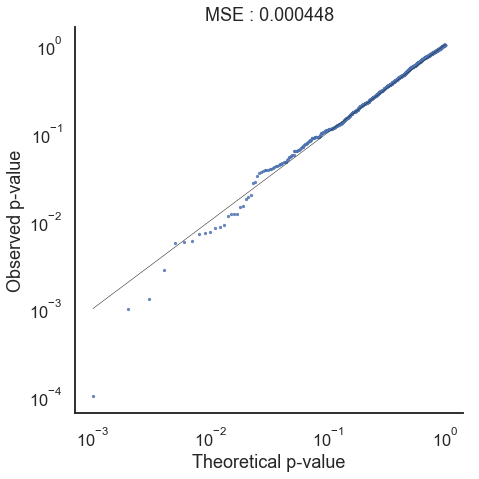

In [217]:
pDf = getdf(pe_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

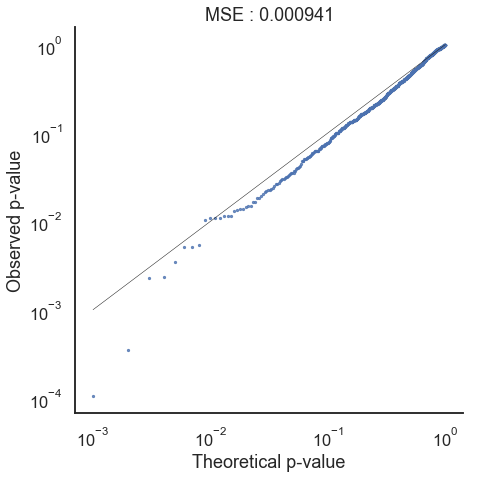

In [218]:
pDf = getdf(p_val_list_[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

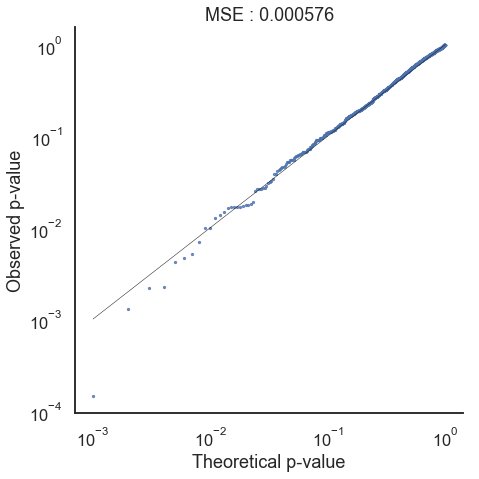

In [219]:
pDf = getdf(pmw_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

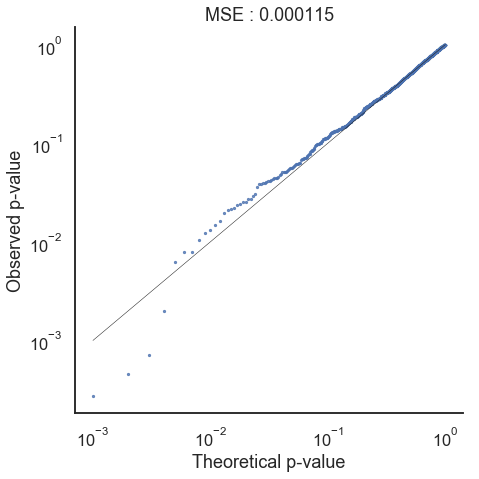

In [220]:
pDf = getdf(pt_list5_2[2], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=150$

# Parallelized shift method

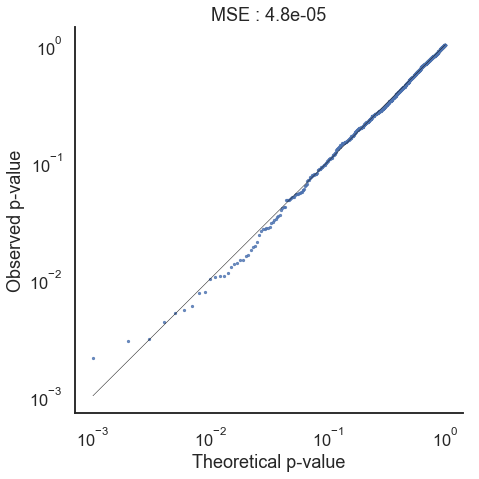

In [228]:
pDf = getdf(pe_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximations

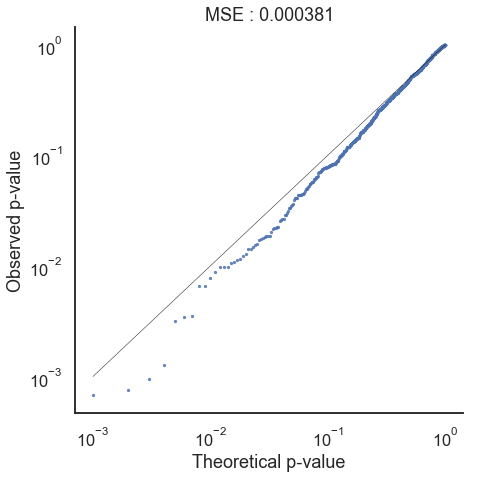

In [229]:
pDf = getdf(p_val_list_[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

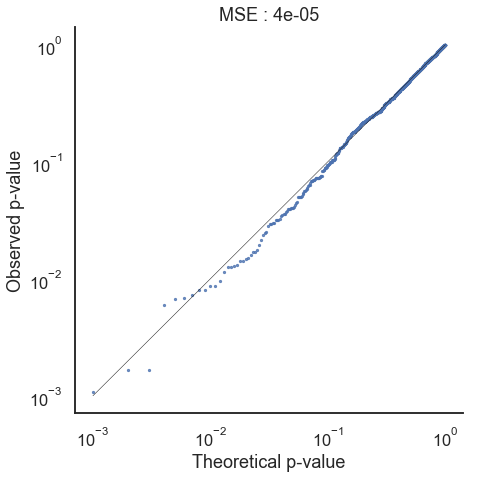

In [230]:
pDf = getdf(pmw_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

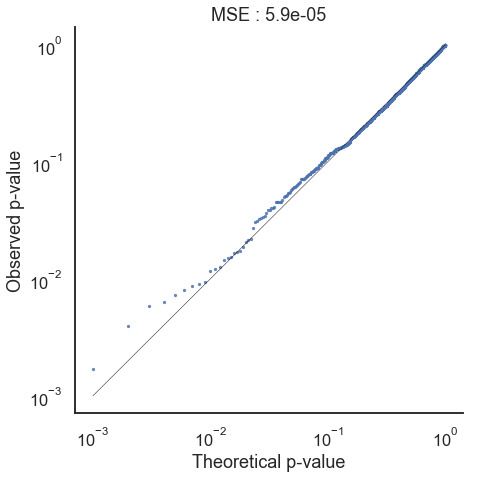

In [231]:
pDf = getdf(pt_list5_2[3], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# $|n|=|m|=200$

# Parallelized exact method

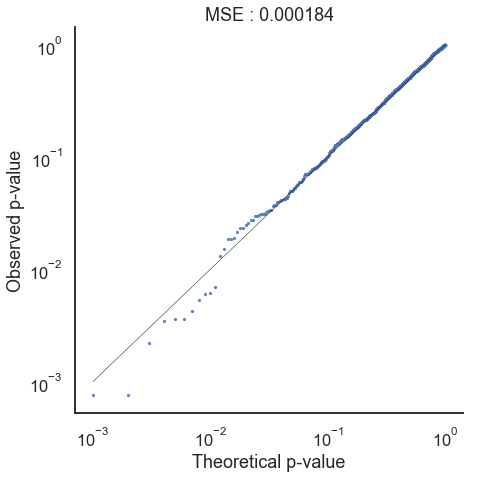

In [232]:
pDf = getdf(pe_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Fast approximation

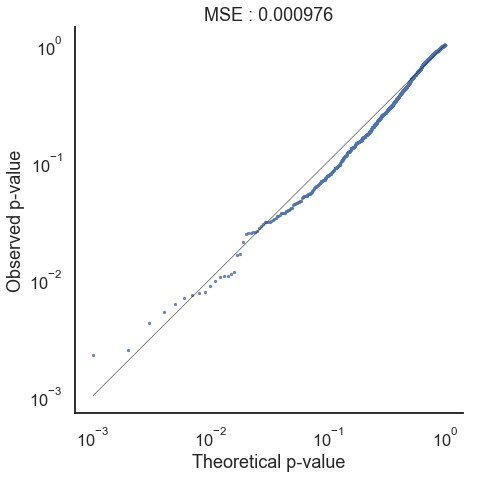

In [233]:
pDf = getdf(p_val_list_[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# Mann Whitney

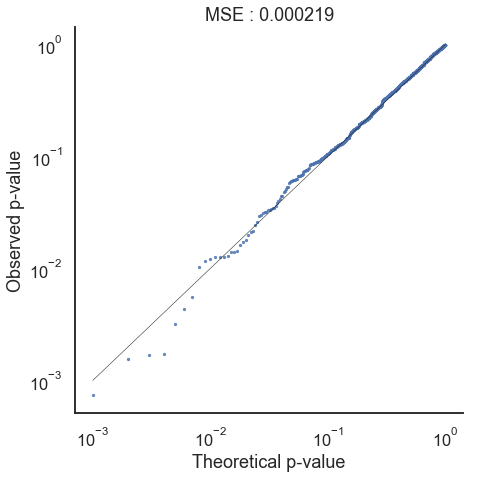

In [234]:
pDf = getdf(pmw_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")

# t-test

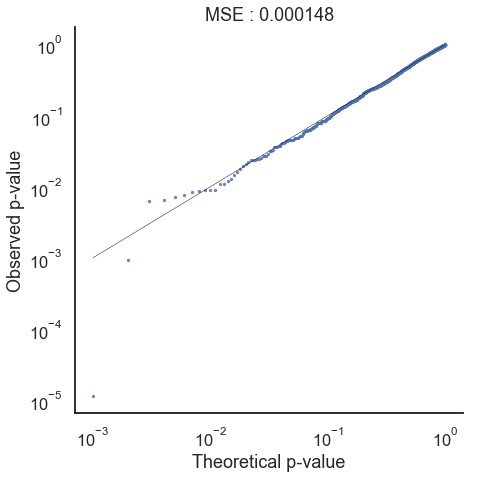

In [235]:
pDf = getdf(pt_list5_2[4], 1000)
my_scatter_plot(pDf,"figures/normal_calibration")